In [8]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
import numpy as np
import pandas as pd
import time
import pickle
import math
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

%tensorflow_version 1.0.0
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.0.0`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.2


In [10]:
import pandas as pd
import numpy as np
import datetime
import time
from matplotlib import pyplot
import math
import random

# read data from csv file and process X, y
def data_loader(data_path):
		# load raw data
		df = pd.read_csv(data_path)

		# clean data with missing values          
		'''drop the rows directly -> mess up the order
			first 24 rows have pm2.5 value that is NaN -> discard
			else: forward filling'''
		df = df[24:].fillna(method='ffill')

		# integrate 'year', 'month', 'day', 'hour', 'No' as one attribute
		df['time'] = df.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
		df.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
		df = df.set_index('time')

		# expand "cbwd" into 4 attributes 'SE', 'cv', 'NW', 'NE'
		df = df.join(pd.get_dummies(df['cbwd'])) # one-hot encoding
		del df['cbwd']

		# df = df.drop('cbwd', axis = 1) # remove the attribute temporarily

		X = df.iloc[:,1:].astype(np.float32)
		y = df['pm2.5'].astype(np.float32).to_frame()
	
		return X, y

# split the data into train, val and test set
from sklearn.model_selection import train_test_split
def train_test_val_split(data, ratio_train, ratio_test, ratio_val):
		X_train, X_middle, y_train, y_middle = train_test_split(data[0], data[1], train_size=ratio_train, test_size=ratio_test + ratio_val, shuffle=True)
		ratio = ratio_val/(1-ratio_train)
		X_val, X_test, y_val, y_test = train_test_split(X_middle, y_middle, train_size=ratio, shuffle=True)
		return (X_train, y_train),(X_val, y_val),(X_test, y_test)

# Z-score normalisation
def data_normalisation(train, val, test):
		X_train, y_train = train[0], train[1]
		X_val, y_val = val[0], val[1]
		X_test, y_test = test[0], test[1]

		mean_x, std_x = X_train.mean(axis=0), X_train.std(axis=0)
		mean_y, std_y = y_train.mean(axis=0), y_train.std(axis=0)
	
		# Use the mean & std of train. Since there's no way for us to know the future.
		(X_train, y_train) = ((X_train-mean_x)/std_x, np.log(np.asarray(y_train) + 1))
		(X_val, y_val) = ((X_val-mean_x)/std_x, np.log(np.asarray(y_val) + 1)) 
		(X_test, y_test) = ((X_test-mean_x)/std_x, np.log(np.asarray(y_test) + 1))

		return (X_train, y_train),(X_val, y_val),(X_test, y_test)

data_path = '/content/drive/My Drive/Colab Notebooks/ML/PRSA_data_2010.1.1-2014.12.31.csv'
X, y = data_loader(data_path)

(X_train, y_train),(X_val, y_val),(X_test, y_test) = train_test_val_split((X.values, y.values), 0.8, 0.1, 0.1)

(X_train, y_train),(X_val, y_val),(X_test, y_test) = data_normalisation((X_train, y_train),(X_val, y_val),(X_test, y_test))

In [11]:
#Network parameters
n_input = 10 
n_hidden1, n_hidden2 = 20, 10
n_output = 1
#Learning parameters 
learning_rate = 0.005
number_epochs = 20000
batch_size = 128

#Defining the input and the output
X_p = tf.placeholder("float", [None, n_input], name='X_p') 
Y_p = tf.placeholder("float", [None, n_output], name='Y_p')

# forward
def multilayer_perceptron(input_d):
    #DEFINING WEIGHTS AND BIASES
    b1 = tf.Variable(tf.random_normal([n_hidden1])) #Biases first hidden layer
    b2 = tf.Variable(tf.random_normal([n_hidden2])) #Biases second hidden layer
    b3 = tf.Variable(tf.random_normal([n_output]))  #Biases output layer
    
    w1 = tf.Variable(tf.random_normal([n_input, n_hidden1]))   #Weights connecting input layer with first hidden layer
    w2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2])) #Weights connecting first hidden layer with second hidden layer 
    w3 = tf.Variable(tf.random_normal([n_hidden2, n_output]))

    layer_1 = tf.nn.softplus(tf.add(tf.matmul(input_d, w1), b1)) #Task of neurons of first hidden layer
    layer_2 = tf.nn.softplus(tf.add(tf.matmul(layer_1, w2), b2)) #Task of neurons of second hidden layer

    out_layer = tf.add(tf.matmul(layer_2, w3),b3,name='output')            #Task of neurons of output layer
    
    return out_layer

# create model
neural_network = multilayer_perceptron(X_p)

# Store parameter for NN model
tf.add_to_collection('pred_network', neural_network)  

# define loss function
# There are 2 kinds of loss function in DL. One for mean squared loss function，another for cross entropy loss function.

# loss_func = tf.reduce_mean(tf.math.squared_difference(neural_network,Y_p)) # MSE


# #RMSE
# mse = tf.keras.losses.MeanSquaredError()
# loss_func_pre = mse(neural_network,Y_p)
# loss_func = tf.cast(tf.sqrt(loss_func_pre),dtype=tf.float32)

# # MAE
# mae = tf.keras.losses.MeanAbsoluteError()
# loss_func = mae(neural_network,Y_p)

#MSE
mse = tf.keras.losses.MeanSquaredError()
loss_func= mse(neural_network,Y_p)
# Store parameter for NN model
tf.add_to_collection('loss', loss_func) 

# # MAPE
# mape = tf.keras.losses.MeanAbsolutePercentageError()
# loss_func = mlse(neural_network,Y_p)

# # msle
# mlse = tf.keras.losses.MeanSquaredLogarithmicError()
# loss_func = mlse(neural_network,Y_p)
# # huber loss
# huber_loss = tf.keras.losses.Huber()
# loss_func = huber_loss(neural_network,Y_p)

# loss_func = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=neural_network,labels=Y_p))
eval_RMSE = tf.cast(tf.sqrt(loss_func),dtype=tf.float32)

# define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_func)

# initializaing variables
init = tf.global_variables_initializer()

In [12]:
def train_model():
      # def train_model():
    train_losses = []
    val_losses = []
    select_epoch_from = 1000
    epochs = []
    batch_iteration = int(len(X_train) / batch_size) + 1
    bestEpoch=0
    least_loss=10

    saver = tf.train.Saver()

    with tf.Session() as sess: 

          sess.run(init)
          start_time = time.clock() 

          #Training epoch 
          for epoch in range(1,number_epochs+1):
              
              n = epoch % batch_iteration
              s = 0 + batch_size * n
              if n == 0:
                e = len(X_train)
              else:
                e = batch_size + batch_size * n
              
              batch_X = np.array(X_train[s:e])
              batch_y = np.array(y_train[s:e])

              _, train_loss = sess.run([optimizer,loss_func], feed_dict={X_p: batch_X, Y_p: batch_y})

              val_loss = loss_func.eval({X_p: X_val, Y_p: y_val})

              if epoch >= select_epoch_from and epoch % 100 == 0:
                  train_losses.append(train_loss)
                  val_losses.append(val_loss)
                  epochs.append(epoch)
                      

              #Display the epoch
              if epoch % 1000 == 0:
                  print("Epoch: %d, "
                        "Training loss: %s, "
                        "Validation loss: %s, " % (epoch, train_loss, val_loss))
                  
          # save the model
          saver.save(sess, '/content/drive/My Drive/Colab Notebooks/ML/parameters/model.ckpt')
          end_time = time.clock()

          print("The totoal training time is: " + str(end_time-start_time))


          pyplot.plot(epochs, train_losses, 'r', label='Training loss', linewidth=1, linestyle='-')
          pyplot.plot(epochs, val_losses, 'b', label='Validation loss', linewidth=3, linestyle='-.')
          pyplot.xlabel('Epoch') 
          pyplot.ylabel('Loss')
          pyplot.title('Training and validation loss')
          pyplot.legend()
          pyplot.figure()
          
          # Test model
          pred = (neural_network) 
          output=neural_network.eval({X_p: X_test}) 

          # plot prediction and labels
          pyplot.plot(y_test[0:500], 'ro', label='Testing labels')
          pyplot.plot(output[0:500], 'bo', label='Predictions')
          pyplot.xlabel('Instances') 
          pyplot.ylabel('Average_log(PM2.5 + 1)')
          pyplot.title('Partial Predictions and labels')
          pyplot.show()

          # # final RMSE
          # rmse_score = sess.run(eval_RMSE,feed_dict={X_p:X_test,Y_p:y_test})
          # print("Average RMSE: " + str(rmse_score))

In [13]:
def load_model():
    with tf.Session() as sess:
        new_saver=tf.train.import_meta_graph('/content/drive/My Drive/Colab Notebooks/ML/parameters/model.ckpt.meta')
        new_saver.restore(sess,'/content/drive/My Drive/Colab Notebooks/ML/parameters/model.ckpt')
        graph = tf.get_default_graph()
        # redefine the structure
        X_p=graph.get_operation_by_name('X_p').outputs[0]
        Y_p=graph.get_operation_by_name('Y_p').outputs[0]
        output=tf.get_collection("pred_network")[0]
        loss = tf.get_collection("loss")[0]

        # retrain
        y_pred = sess.run(output, feed_dict={X_p: X_test})
        loss_score = sess.run(loss, feed_dict={X_p: X_test,Y_p:y_test})

        # plot prediction and labels
        pyplot.plot(y_test[0:500], 'ro', label='Testing labels')
        pyplot.plot(y_pred[0:500], 'bo', label='Predictions')
        pyplot.xlabel('Instances') 
        pyplot.ylabel('Average_log(PM2.5 + 1)')
        pyplot.title('Partial Predictions and labels')
        pyplot.show()

        print("Loss score: " + str(loss_score))


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Colab Notebooks/ML/parameters/model.ckpt


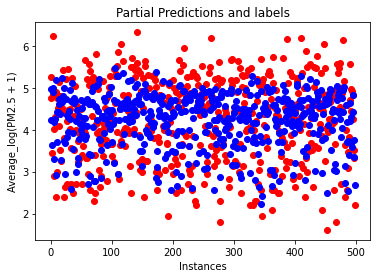

Loss score: 0.5754898


In [14]:
# if you get an error like this "At least two variables have the same name: Variable",please choose Runtime-> Restart runtime, then rerun this program
# make sure there are ckpt files in your folder, if not, try to train the model at first
# isTrain = False
isTrain = True

if isTrain:
  load_model()
else:
  train_model()